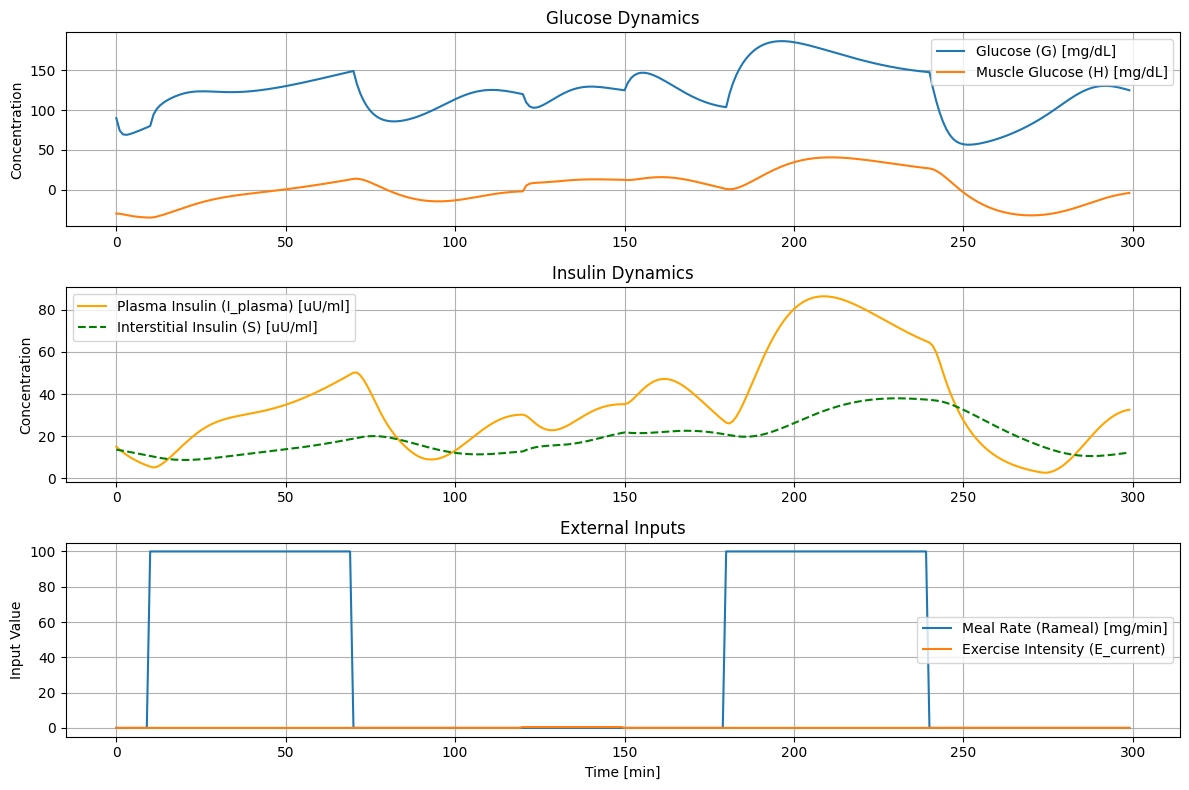

In [ ]:
from model import GlucoseDynamicsSimulator
from scipy.integrate import odeint
import numpy as np

def get_inputs_for_t( t):
    Rameal_current = 0.0
    E_current = 0.0

    meal_event_occurred = False
    exercise_event_occurred = False

    # Meal event: 6000 mg glucose over 60 minutes, starting at t=10 and t=180
    if 10 <= t < 70: # Meal 1 starts at 10 min, lasts 60 min
        Rameal_current = 6000 / 60 # mg/min
        if t == 10: # Flag as event only at the start of the meal window
            meal_event_occurred = True
    elif 180 <= t < 240: # Meal 2 starts at 180 min, lasts 60 min
        Rameal_current = 6000 / 60 # mg/min
        if t == 180: # Flag as event only at the start of the meal window
            meal_event_occurred = True

    # Exercise event: E=0.5 for 30 minutes, starting at t=120
    if 120 <= t < 150: # Exercise starts at 120 min, lasts 30 min
        E_current = 0.5
        if t == 120: # Flag as event only at the start of the exercise window
            exercise_event_occurred = True

    return (Rameal_current, E_current, meal_event_occurred, exercise_event_occurred)

# Initialize the simulator and initial conditions
sim = GlucoseDynamicsSimulator()
y0 = sim.initial_conditions()
t_span = np.arange(0, 300, 1) # Simulate for 300 minutes, 1-minute steps

def odes_for_solver(y, t, sim_instance):
    """
    Wrapper for sim.odes to be used with odeint.
    It takes the current time 't' and generates inputs dynamically.
    """
    inputs = get_inputs_for_t(t)
    return sim_instance.odes(y, inputs)

# Solve the ODEs
solution = odeint(odes_for_solver, y0, t_span, args=(sim,))

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_span, solution[:, 0], label='Glucose (G) [mg/dL]')
plt.plot(t_span, solution[:, 1], label='Muscle Glucose (H) [mg/dL]')
plt.ylabel('Concentration')
plt.title('Glucose Dynamics')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_span, solution[:, 7], label='Plasma Insulin (I_plasma) [uU/ml]', color='orange') # I_plasma is the last state variable
plt.plot(t_span, solution[:, 2], label='Interstitial Insulin (S) [uU/ml]', color='green', linestyle='--')
plt.ylabel('Concentration')
plt.title('Insulin Dynamics')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
rameal_over_time = [get_inputs_for_t(t)[0] for t in t_span]
e_current_over_time = [get_inputs_for_t(t)[1] for t in t_span]
plt.plot(t_span, rameal_over_time, label='Meal Rate (Rameal) [mg/min]')
plt.plot(t_span, e_current_over_time, label='Exercise Intensity (E_current)')
plt.ylabel('Input Value')
plt.xlabel('Time [min]')
plt.title('External Inputs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Sample Reward function

In [ ]:
# Assuming you have the current_state (y vector) and previous_glucose_level available
# from the previous step for variability calculation.
# You might need to store previous_glucose_level in self for this.

# --- Reward Calculation Logic within GlucoseEnv.step() ---

# Initialize reward for this step
reward = 0.0

# 1. Action Penalty (optional, to encourage efficiency)
# You already have this in your GlucoseEnv example:
# if action != 0: # If any action is taken (not 'no action')
#     reward += self.penalty_action # e.g., -0.01

# 2. State-Dependent Glucose Reward/Penalty
glucose_level = self.current_state[0] # Plasma Glucose (G)
time_since_last_meal = self.current_state[5] # From the state vector

if time_since_last_meal > 8 * 60: # Fasting State (e.g., > 8 hours = 480 minutes)
    if 70 <= glucose_level <= 100:
        reward += 100.0
    elif 101 <= glucose_level <= 125:
        reward += -30.0
    elif glucose_level < 70: # Hypoglycemia
        reward += -100.0
    elif glucose_level > 125: # Hyperglycemia
        reward += -100.0

elif time_since_last_meal <= 2 * 60: # Post-Eating State (e.g., <= 2 hours = 120 minutes)
    if glucose_level <= 140:
        reward += 80.0
    elif 141 <= glucose_level <= 199:
        reward += -20.0
    elif glucose_level < 70: # Hypoglycemia
        reward += -100.0
    elif glucose_level > 200: # Hyperglycemia
        reward += -100.0

else: # Intermediate State (2 hours < Time Since Last Meal <= 8 hours)
    if 70 <= glucose_level <= 120:
        reward += 50.0
    elif 121 <= glucose_level <= 140:
        reward += -15.0
    elif glucose_level < 70: # Hypoglycemia
        reward += -100.0
    elif glucose_level > 140: # Hyperglycemia
        reward += -100.0

# 3. Penalize High Variability when "Stable" (No Active Action/Meal/Exercise Input)
# This requires storing the glucose level from the previous step.
# In your GlucoseEnv, you could add: self.previous_glucose_level = glucose_level at the end of step()
# And initialize it in reset().

# Check if there's no active meal or exercise input from the agent *this step*
# (assuming current_meal_rate and current_exercise_level reflect agent's current inputs, not physiological carry-over)
agent_inactive = (self.current_meal_rate == 0 and self.current_exercise_level == 0)

# Also check if G is in a 'reasonable' zone before penalizing variability too much,
# as large changes are expected when outside target or during/after an action.
if hasattr(self, 'previous_glucose_level') and agent_inactive and \
   (70 <= glucose_level <= 180): # Only penalize variability when in a somewhat stable range
    
    glucose_change = abs(glucose_level - self.previous_glucose_level)
    
    # Penalize if change is above a certain threshold (e.g., 5 mg/dL per minute)
    # You'll need to tune this threshold (e.g., 5.0) and penalty (e.g., -0.5)
    variability_threshold = 5.0
    variability_penalty_per_unit_over_threshold = -0.5 # Example value
    
    if glucose_change > variability_threshold:
        reward += variability_penalty_per_unit_over_threshold * (glucose_change - variability_threshold)

# 4. Critical State Penalties (for episode termination)
# These are usually large, one-time penalties for failure states.
# You already have this in your GlucoseEnv example:
# done = False
# if glucose_level < 40 or glucose_level > 450: # Critical thresholds
#     done = True
#     reward -= 100 # Severe penalty for ending in a critical state due to failure

# Store current glucose for next step's variability calculation
self.previous_glucose_level = glucose_level

# --- End Reward Calculation ---